In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import (figure, title, boxplot, xticks, subplot, hist,
                               xlabel, ylim, yticks, show, savefig, plot, ylabel,
                               colorbar, imshow)
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from toolbox_02450 import rocplot, confmatplot
from sklearn.discriminant_analysis import StandardScaler


from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from numpy import cov


In [4]:
df = pd.read_csv('hour.csv')

In [5]:
# PREPROCESSING

# Removing useless attributes
df = df.drop('dteday', axis=1)
df = df.drop('instant', axis=1)
df = df.drop('yr', axis=1)

# Applying sqrt to "cnt" (to make it a continuous variable)
df['cnt'] = np.sqrt(df['cnt'])

# Removing deprecated attributes after the sqrt transformation (cnt = casual + registered)
df = df.drop('casual', axis=1)
df = df.drop('registered', axis=1)

df.head()

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,4.000000
1,1,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,6.324555
2,1,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5.656854
3,1,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3.605551
4,1,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1.000000


temp
25.42    726
27.06    693
26.24    692
28.70    690
24.60    675
14.76    671
13.94    645
12.30    641
16.40    614
13.12    611
22.96    579
29.52    570
22.14    569
18.86    559
10.66    559
21.32    556
17.22    548
20.50    531
9.84     522
30.34    516
18.04    507
9.02     421
31.16    396
15.58    372
8.20     354
27.88    349
32.80    325
23.78    305
11.48    301
19.68    288
6.56     230
33.62    213
31.98    169
7.38     155
5.74     138
34.44    138
35.26    131
36.90     90
4.92      76
36.08     53
4.10      51
37.72     49
38.54     17
3.28      17
0.82      17
1.64      16
2.46      16
39.36     16
40.18      1
41.00      1
Name: count, dtype: int64


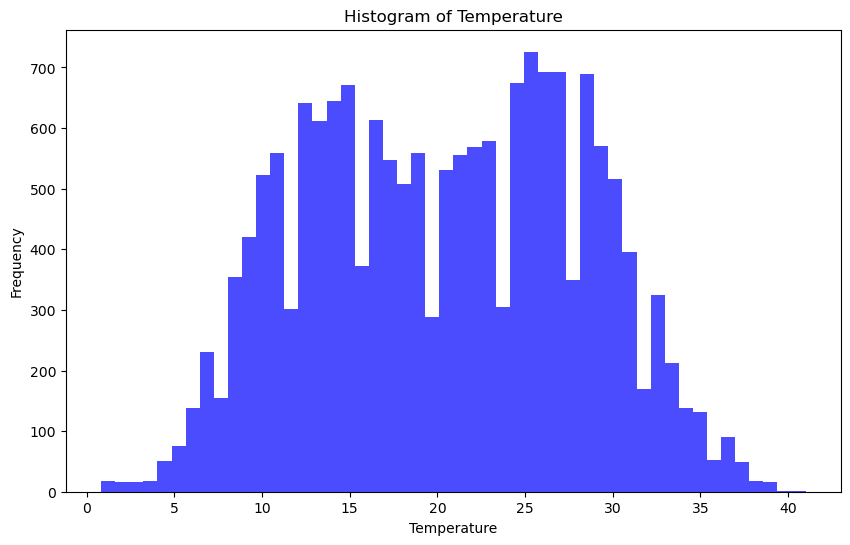

In [6]:
df['temp'] = df['temp'] * 41
print(df['temp'].value_counts())


# Plot a histogram for the 'temp' attribute
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.hist(df['temp'], bins=50, color='blue', alpha=0.7)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Histogram of Temperature')
plt.show()

In [7]:
df.temp.describe()

count    17379.000000
mean        20.376474
std          7.894801
min          0.820000
25%         13.940000
50%         20.500000
75%         27.060000
max         41.000000
Name: temp, dtype: float64

In [8]:
# Quantize the temperature attribute into 4 levels

bins = [0, 10, 20, 30, 41]
names = ['cold', 'cool', 'warm', 'hot']

df['temp'] = pd.cut(df['temp'], bins, labels=names)


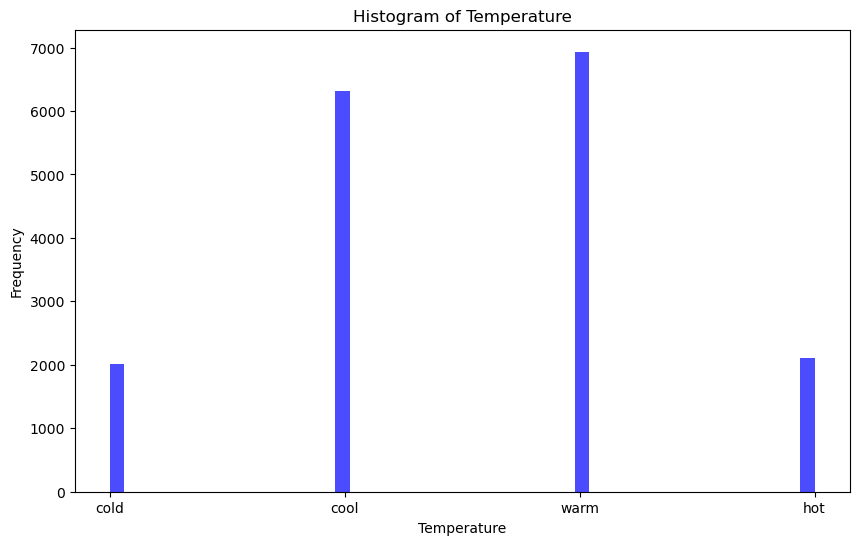

In [9]:
# Plot a histogram for the 'temp' attribute
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.hist(df['temp'], bins=50, color='blue', alpha=0.7)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Histogram of Temperature')
plt.show()

In [10]:
# Define X and y
X = df.drop(['holiday', 'weekday', 'workingday', 'atemp', 'temp'], axis=1).values
y = df['temp'].values

attributeNames = df.columns.drop(['holiday', 'weekday', 'workingday', 'atemp', 'temp']).tolist()
classNames = names
N, M = X.shape
C = len(classNames)

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, stratify=y)

# Standardize the training and set set based on training set mean and std
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Logistic regression

Minimum test error: 49.37 % at 1e1.25


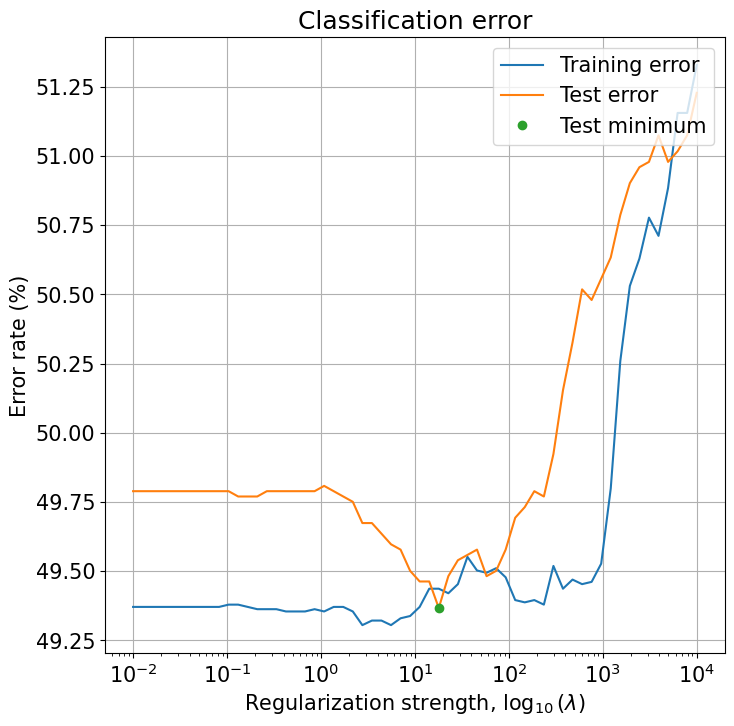

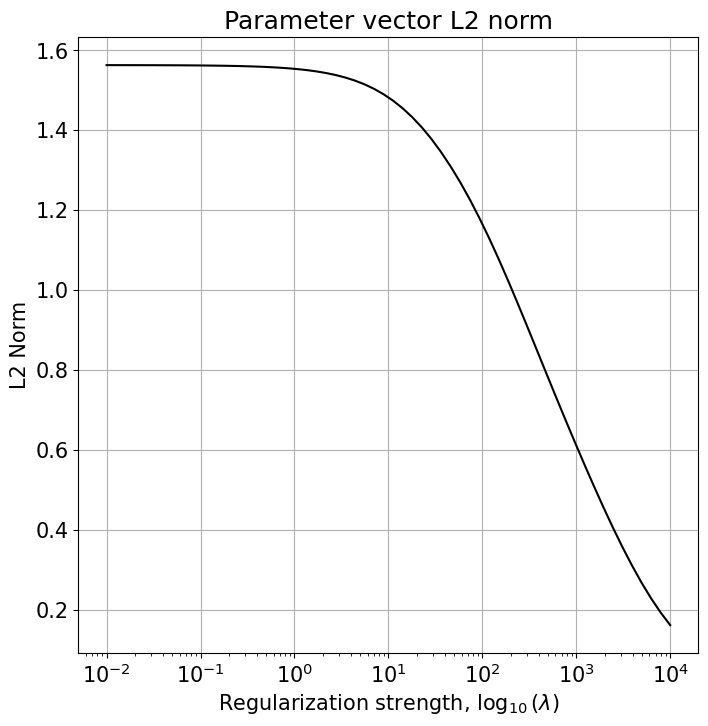

In [11]:
# Fit regularized logistic regression model to training data
lambda_interval = np.logspace(-2, 4, 60)
train_error_rate = np.zeros(len(lambda_interval))
test_error_rate = np.zeros(len(lambda_interval))
coefficient_norm = np.zeros(len(lambda_interval))
for k in range(0, len(lambda_interval)):
    mdl = LogisticRegression(penalty='l2', C=1/lambda_interval[k], multi_class='multinomial', solver='lbfgs')
    
    mdl.fit(X_train, y_train)

    y_train_est = mdl.predict(X_train).T
    y_test_est = mdl.predict(X_test).T
    
    train_error_rate[k] = np.sum(y_train_est != y_train) / len(y_train)
    test_error_rate[k] = np.sum(y_test_est != y_test) / len(y_test)

    w_est = mdl.coef_[0] 
    coefficient_norm[k] = np.sqrt(np.sum(w_est**2))

min_error = np.min(test_error_rate)
opt_lambda_idx = np.argmin(test_error_rate)
opt_lambda = lambda_interval[opt_lambda_idx]

font_size = 15
plt.rcParams.update({'font.size': font_size})

plt.figure(figsize=(8,8))
#plt.plot(np.log10(lambda_interval), train_error_rate*100)
#plt.plot(np.log10(lambda_interval), test_error_rate*100)
#plt.plot(np.log10(opt_lambda), min_error*100, 'o')
plt.semilogx(lambda_interval, train_error_rate*100)
plt.semilogx(lambda_interval, test_error_rate*100)
plt.semilogx(opt_lambda, min_error*100, 'o')
print("Minimum test error: " + str(np.round(min_error*100,2)) + ' % at 1e' + str(np.round(np.log10(opt_lambda),2)))
plt.xlabel('Regularization strength, $\log_{10}(\lambda)$')
plt.ylabel('Error rate (%)')
plt.title('Classification error')
plt.legend(['Training error','Test error','Test minimum'],loc='upper right')
plt.grid()
plt.show()    

plt.figure(figsize=(8,8))
plt.semilogx(lambda_interval, coefficient_norm,'k')
plt.ylabel('L2 Norm')
plt.xlabel('Regularization strength, $\log_{10}(\lambda)$')
plt.title('Parameter vector L2 norm')
plt.grid()
plt.show()    


## KNN

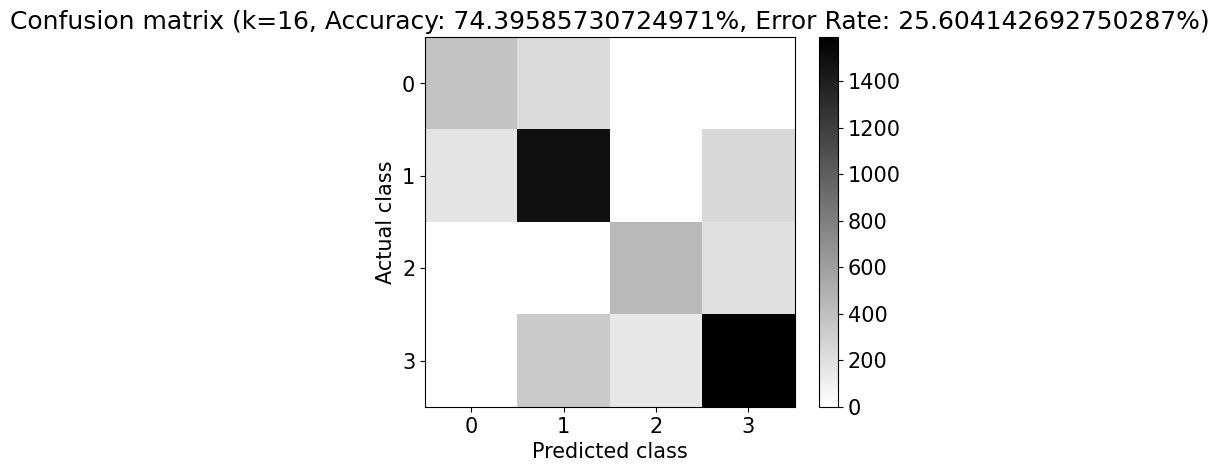

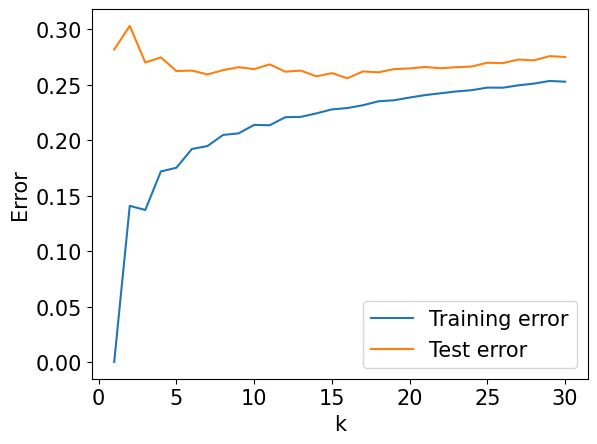

In [18]:
from sklearn.model_selection import GridSearchCV # CHECK WITH T.A: is this allowed?
import seaborn as sns # CHECK WITH T.A: is this allowed?

# K-nearest neighbors

# Distance metric (corresponds to 2nd norm, euclidean distance).
# You can set dist=1 to obtain manhattan distance (cityblock distance).
dist=2
metric = 'minkowski'
metric_params = {} # no parameters needed for minkowski

# You can set the metric argument to 'cosine' to determine the cosine distance
#metric = 'cosine' 
#metric_params = {} # no parameters needed for cosine

# To use a mahalonobis distance, we need to input the covariance matrix, too:
#metric='mahalanobis'
#metric_params={'V': cov(X_train, rowvar=False)}

# Range of k values to try
k_values = range(1, 31)

# Choose a specific k value for which to display the confusion matrix
k_display = 16

train_errors = []
test_errors = []

for K in k_values:
    knclassifier = KNeighborsClassifier(n_neighbors=K, p=dist, 
                                        metric=metric,
                                        metric_params=metric_params)
    knclassifier.fit(X_train, y_train)
    
    # Compute training error
    y_train_est = knclassifier.predict(X_train)
    train_error = np.mean(y_train_est != y_train)
    train_errors.append(train_error)
    
    # Compute test error
    y_est = knclassifier.predict(X_test)
    test_error = np.mean(y_est != y_test)
    test_errors.append(test_error)

    # Compute and plot confusion matrix for the chosen k value
    if K == k_display:
        cm = confusion_matrix(y_test, y_est)
        accuracy = 100*cm.diagonal().sum()/cm.sum()
        error_rate = 100-accuracy

        plt.figure()
        plt.imshow(cm, cmap='binary', interpolation='None')
        plt.colorbar()
        plt.xticks(range(C))
        plt.yticks(range(C))
        plt.xlabel('Predicted class')
        plt.ylabel('Actual class')
        plt.title('Confusion matrix (k={0}, Accuracy: {1}%, Error Rate: {2}%)'.format(K, accuracy, error_rate))

# Plot training and test error as a function of k
plt.figure()
plt.plot(k_values, train_errors, label='Training error')
plt.plot(k_values, test_errors, label='Test error')
plt.legend()
plt.xlabel('k')
plt.ylabel('Error')
plt.show()

In [17]:
# find the minimum test error and optimal k, and substitute in the code above
k_star = np.argmin(test_errors)
print('Optimal k: {0}'.format(k_values[k_star]))

Optimal k: 16


## Baseline method

In [13]:
def baseline_method(train, test):
    # Extract the output values
    output_values = [row for row in train]
    
    # Find the most common output value in the training set
    prediction = max(set(output_values), key=output_values.count)
    
    # Create a list of predictions for each test case based on the most common output value
    predicted = [prediction for i in range(len(test))]
    
    return predicted

In [19]:
# Compute the predictions using the baseline method
y_pred = baseline_method(y_train, y_test)

# Compute the classification error rate
baseline_error = np.mean(y_pred != y_test)

print('Baseline error rate: {0}%'.format(baseline_error*100))


Baseline error rate: 60.08822401227465%
